# Normalización de las imágenes

Como vimos en el anterior tema, es importante normalizar los datos que entran a una red neuronal. Con las imágenes pasa lo mismo

## División entre 255

La mayoría de las veces nos enfrentamos a imágenes en formato RGB, donde cada uno de sus píxeles puede valer entre 0 y 255, por lo que normalmente se divide la matriz entre 255 para que de esta manera, ahora cada pixel valga entre 0 y 1

## Media y desviación estandar

Además de dividir entre 255, se puede restar la media y dividir entre la desviación estandar. De esta manera el conjunto de datos ahora tendrá media 0 y desviación estandar 1. Esto también lo vimos en el tema anterior

Pero en el caso de imágenes a veces hay que tener cuidado, porque si no se tiene un dataset muy variado puede que no sea recomendable corregir por la media y la desviación estandar. Depende de si las imágenes que se le van a meter luego a la red son muy diferentes o no de las imágenes con las que se le ha entrenado.
Sin embargo, con un dataset de imágenes grande y muy variado como Imagenet, que recordamos que son millones de imágenes de 1000 diferentes categorías, sí merece la pena corregir con la media y la desviación estandar

## Normalización en Pytorch

Vamos a hacer el mismo ejemplo que antes, entrenar una red con el dataset de [Intel Image Classification](https://www.kaggle.com/datasets/puneet6060/intel-image-classification).

### Dataframes

Creamos los dataframes

In [1]:
# Python list of files in the directory
import os
import pandas as pd

df_building = pd.DataFrame({'folder': 'data/intel/seg_train/seg_train/buildings/', 'filename': os.listdir('data/intel/seg_train/seg_train/buildings'), 'class': 'buildings'})
df_forest = pd.DataFrame({'folder': 'data/intel/seg_train/seg_train/forest/', 'filename': os.listdir('data/intel/seg_train/seg_train/forest'), 'class': 'forest'})
df_glacier = pd.DataFrame({'folder': 'data/intel/seg_train/seg_train/glacier/', 'filename': os.listdir('data/intel/seg_train/seg_train/glacier'), 'class': 'glacier'})
df_mountain = pd.DataFrame({'folder': 'data/intel/seg_train/seg_train/mountain/', 'filename': os.listdir('data/intel/seg_train/seg_train/mountain'), 'class': 'mountain'})
df_sea = pd.DataFrame({'folder': 'data/intel/seg_train/seg_train/sea/', 'filename': os.listdir('data/intel/seg_train/seg_train/sea'), 'class': 'sea'})
df_street = pd.DataFrame({'folder': 'data/intel/seg_train/seg_train/street/', 'filename': os.listdir('data/intel/seg_train/seg_train/street'), 'class': 'street'})
df_train = pd.concat([df_building, df_forest, df_glacier, df_mountain, df_sea, df_street], ignore_index=True)
df_train['path'] = df_train['folder'] + df_train['filename']
cols = df_train.columns.tolist()
cols = cols[-1:] + cols[-2:-1]
df_train = df_train[cols]
df_train.head()

,path,class
0,data/intel/seg_train/seg_train/buildings/19036...,buildings
1,data/intel/seg_train/seg_train/buildings/14883...,buildings
2,data/intel/seg_train/seg_train/buildings/904.jpg,buildings
3,data/intel/seg_train/seg_train/buildings/14081...,buildings
4,data/intel/seg_train/seg_train/buildings/14456...,buildings


In [2]:
df_building = pd.DataFrame({'folder': 'data/intel/seg_test/seg_test/buildings/', 'filename': os.listdir('data/intel/seg_test/seg_test/buildings'), 'class': 'buildings'})
df_forest = pd.DataFrame({'folder': 'data/intel/seg_test/seg_test/forest/', 'filename': os.listdir('data/intel/seg_test/seg_test/forest'), 'class': 'forest'})
df_glacier = pd.DataFrame({'folder': 'data/intel/seg_test/seg_test/glacier/', 'filename': os.listdir('data/intel/seg_test/seg_test/glacier'), 'class': 'glacier'})
df_mountain = pd.DataFrame({'folder': 'data/intel/seg_test/seg_test/mountain/', 'filename': os.listdir('data/intel/seg_test/seg_test/mountain'), 'class': 'mountain'})
df_sea = pd.DataFrame({'folder': 'data/intel/seg_test/seg_test/sea/', 'filename': os.listdir('data/intel/seg_test/seg_test/sea'), 'class': 'sea'})
df_street = pd.DataFrame({'folder': 'data/intel/seg_test/seg_test/street/', 'filename': os.listdir('data/intel/seg_test/seg_test/street'), 'class': 'street'})
df_test = pd.concat([df_building, df_forest, df_glacier, df_mountain, df_sea, df_street], ignore_index=True)
df_test['path'] = df_test['folder'] + df_test['filename']
cols = df_test.columns.tolist()
cols = cols[-1:] + cols[-2:-1]
df_test = df_test[cols]
df_test.head()

,path,class
0,data/intel/seg_test/seg_test/buildings/21360.jpg,buildings
1,data/intel/seg_test/seg_test/buildings/20805.jpg,buildings
2,data/intel/seg_test/seg_test/buildings/21955.jpg,buildings
3,data/intel/seg_test/seg_test/buildings/21779.jpg,buildings
4,data/intel/seg_test/seg_test/buildings/20611.jpg,buildings


In [3]:
df_pred = pd.DataFrame({'folder': 'data/intel/seg_pred/seg_pred/', 'filename': os.listdir('data/intel/seg_pred/seg_pred')})
df_pred['path'] = df_pred['folder'] + df_pred['filename']
cols = df_pred.columns.tolist()
cols = cols[2]
df_pred = df_pred[cols]
df_pred.head()

0     data/intel/seg_pred/seg_pred/8858.jpg
1    data/intel/seg_pred/seg_pred/17415.jpg
2    data/intel/seg_pred/seg_pred/13407.jpg
3    data/intel/seg_pred/seg_pred/21854.jpg
4    data/intel/seg_pred/seg_pred/19870.jpg
Name: path, dtype: object

Creamos un diccionario con las clases

In [4]:
classes = {'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}

### Dataset normalizado (dividiendo las imágenes entre 255)

Creamos un dataset que normalice las imágenes

In [5]:
import torch
import cv2

class IntelDataset_255(torch.utils.data.Dataset):
    def __init__(self, df, pred=False,):
        self.df = df
        self.pred = pred

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if not self.pred:
            img = cv2.imread(self.df.iloc[idx, 0])  # Read image
        else:
            img = cv2.imread(self.df.iloc[idx]) # Read image
        if img.shape[0] != 150 or img.shape[1] != 150:  # Resize image if needed
            img = cv2.resize(img, (150, 150))
        img = torch.from_numpy(img).permute(2, 0, 1).float()    # Convert to tensor and permute dimensions
        img_norm = img / 255.0  # Normalize image
        if not self.pred:
            label = torch.tensor(classes[self.df.iloc[idx, 1]]) # Get label
            return img, img_norm, label
        return img, img_norm

ds_train_255 = IntelDataset_255(df_train)
ds_test_255 = IntelDataset_255(df_test)
ds_pred_255 = IntelDataset_255(df_pred, pred=True)

Veamos una muestra

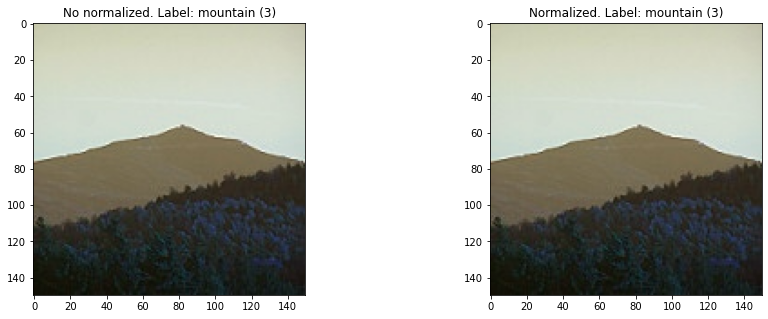

No normalized:	Max value: 255.0,	Min value: 1.0
Normalized:	Max value: 1.0,		Min value: 0.003921568859368563


In [6]:
import numpy as np
import matplotlib.pyplot as plt

idx = np.random.randint(0, len(ds_train_255))
sample_img, sample_img_norm, sample_label = ds_train_255[idx]

key = [k for k, v in classes.items() if v == sample_label][0]

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].imshow(sample_img.permute(1, 2, 0).numpy().astype(np.uint8))
ax[0].set_title(f"No normalized. Label: {key} ({sample_label})")
ax[1].imshow(sample_img_norm.permute(1, 2, 0).numpy())
ax[1].set_title(f"Normalized. Label: {key} ({sample_label})")
plt.show()
print(f"No normalized:\tMax value: {sample_img.max()},\tMin value: {sample_img.min()}")
print(f"Normalized:\tMax value: {sample_img_norm.max()},\t\tMin value: {sample_img_norm.min()}")

Al dividir entre 255 vemos que la representación de la imagen no cambia, pero sí el valor máximo y el mínimo

### Dataset normalizado y corregido con media y desviación estandar

Creamos un dataset que normalice las imágenes yo corrija con la media y la desviación estandar

In [7]:
import torch
import torchvision
import cv2

class IntelDataset_norm(torch.utils.data.Dataset):
    def __init__(self, df, pred=False,):
        self.df = df
        self.pred = pred
        self.mean = [0.485, 0.456, 0.406]
        self.std = [0.229, 0.224, 0.225]
        self.norm = torchvision.transforms.Normalize(self.mean, self.std)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if not self.pred:
            img = cv2.imread(self.df.iloc[idx, 0])  # Read image
        else:
            img = cv2.imread(self.df.iloc[idx]) # Read image
        if img.shape[0] != 150 or img.shape[1] != 150:  # Resize image if needed
            img = cv2.resize(img, (150, 150))
        img = torch.from_numpy(img).permute(2, 0, 1).float()    # Convert to tensor and permute dimensions
        img_norm = img / 255.0  # Normalize image
        img_norm = self.norm(img_norm) # Standardize image
        if not self.pred:
            label = torch.tensor(classes[self.df.iloc[idx, 1]]) # Get label
            return img, img_norm, label
        return img, img_norm

ds_train_norm = IntelDataset_norm(df_train)
ds_test_norm = IntelDataset_norm(df_test)
ds_pred_norm = IntelDataset_norm(df_pred, pred=True)

Veamos una muestra

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


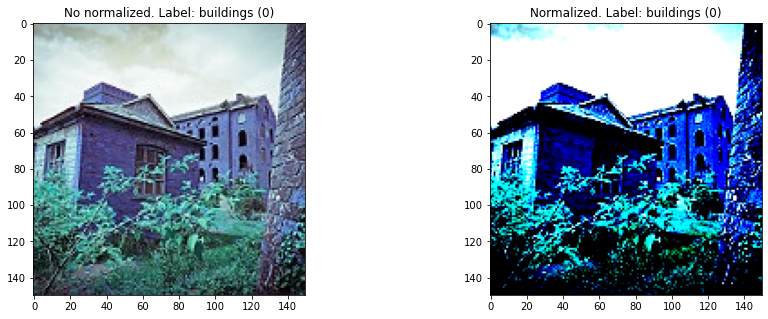

No normalized:	Max value: 255.0,	Min value: 0.0
Normalized:	Max value: 2.640000104904175,		Min value: -2.1179039478302


In [8]:
import numpy as np
import matplotlib.pyplot as plt

idx = np.random.randint(0, len(ds_train_norm))
sample_img, sample_img_norm, sample_label = ds_train_norm[idx]

key = [k for k, v in classes.items() if v == sample_label][0]

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].imshow(sample_img.permute(1, 2, 0).numpy().astype(np.uint8))
ax[0].set_title(f"No normalized. Label: {key} ({sample_label})")
ax[1].imshow(sample_img_norm.permute(1, 2, 0).numpy())
ax[1].set_title(f"Normalized. Label: {key} ({sample_label})")
plt.show()
print(f"No normalized:\tMax value: {sample_img.max()},\tMin value: {sample_img.min()}")
print(f"Normalized:\tMax value: {sample_img_norm.max()},\t\tMin value: {sample_img_norm.min()}")

Vemos que al dividir entre 255 y corregir con la media y desviación estandar de Imagenet, cambia tanto la visualización de la imagen como el máximo y el mínimo

### Dataloaders

Creamos dos dataloaders para los dos datasets

In [9]:
BS_train = 32
BS_test = 32

dl_train_255 = torch.utils.data.DataLoader(ds_train_255, batch_size=BS_train, shuffle=True)
dl_test_255 = torch.utils.data.DataLoader(ds_test_255, batch_size=BS_test, shuffle=True)

dl_train_norm = torch.utils.data.DataLoader(ds_train_norm, batch_size=BS_train, shuffle=True)
dl_test_norm = torch.utils.data.DataLoader(ds_test_norm, batch_size=BS_test, shuffle=True)

In [10]:
batch_img, batch_img_255, batch_label_255 = next(iter(dl_train_255))
print(batch_img_255.shape)

torch.Size([32, 3, 150, 150])


In [11]:
batch_img, batch_img_norm, batch_label_norm = next(iter(dl_train_norm))
print(batch_img_norm.shape)

torch.Size([32, 3, 150, 150])


### Model

Creamos dos modelos para los dos tipos  de detasets

In [12]:
num_clases = len(classes)
num_clases

6

In [13]:
from torchvision.models import resnet50, ResNet50_Weights

model_255 = resnet50(weights=ResNet50_Weights.DEFAULT)
model_255.fc = torch.nn.Linear(model_255.fc.in_features, len(classes))

model_norm = resnet50(weights=ResNet50_Weights.DEFAULT)
model_norm.fc = torch.nn.Linear(model_norm.fc.in_features, len(classes))

model_255.fc.out_features, model_norm.fc.out_features

(6, 6)

In [14]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model_255.to(device)
model_norm.to(device)
print("Using {} device".format(device))

Using cuda device


### Entrenamiento

In [15]:
LR = 1e-3
loss_fn = torch.nn.CrossEntropyLoss()
optimizer_255 = torch.optim.Adam(model_255.parameters(), lr=LR, weight_decay=1e-5)
optimizer_norm = torch.optim.Adam(model_norm.parameters(), lr=LR, weight_decay=1e-5)

In [16]:
num_prints = 2

def train_loop(dataloader, model, loss_fn, optimizer, device):
    size = len(dataloader.dataset)
    mul = 1
    model.train()
    mean_loss = 0
    num_batches = len(dataloader)

    for batch, (_, X, y) in enumerate(dataloader):
        # X and y to device
        X, y = X.to(device), y.to(device)

        # Compute prediction and loss
        preds = model(X)
        loss = loss_fn(preds, y)
        mean_loss += loss.item()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (batch+1) % int(len(dataloader)/num_prints) == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            mul += 1
    
    return mean_loss/num_batches


def val_loop(dataloader, model, loss_fn, device):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    val_loss, correct = 0, 0
    model.eval()

    with torch.no_grad():
        for _, X, y in dataloader:
            # X and y to device
            X, y = X.to(device), y.to(device)
            
            preds = model(X)
            val_loss += loss_fn(preds, y).item()
            # print(X.shape, preds.shape, preds.argmax(1), y)
            correct += (preds.argmax(1) == y).type(torch.float).sum().item()

    val_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {val_loss:>8f} \n")

    return val_loss, correct

Entrenamos los dos modelos con los mismos parámetros que antes

In [17]:
epochs = 12
losses_255_train = []
losses_255_val = []
accuracies_255_val = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    mean_loss =  train_loop(dl_train_255, model_255, loss_fn, optimizer_255, device)
    losses_255_train.append(mean_loss)
    mean_loss, accuracy = val_loop(dl_test_255, model_255, loss_fn, device)
    losses_255_val.append(mean_loss)
    accuracies_255_val.append(accuracy)
print("Done!")

Epoch 1
-------------------------------
loss: 0.510513  [ 6976/14034]
loss: 0.623268  [13984/14034]
Test Error: 
 Accuracy: 84.8%, Avg loss: 0.409828 

Epoch 2
-------------------------------
loss: 0.520100  [ 6976/14034]
loss: 0.220426  [13984/14034]
Test Error: 
 Accuracy: 85.4%, Avg loss: 0.430420 

Epoch 3
-------------------------------
loss: 0.184180  [ 6976/14034]
loss: 0.215480  [13984/14034]
Test Error: 
 Accuracy: 88.7%, Avg loss: 0.337976 

Epoch 4
-------------------------------
loss: 0.115563  [ 6976/14034]
loss: 0.444631  [13984/14034]
Test Error: 
 Accuracy: 88.7%, Avg loss: 0.337995 

Epoch 5
-------------------------------
loss: 0.126957  [ 6976/14034]
loss: 0.360213  [13984/14034]
Test Error: 
 Accuracy: 89.0%, Avg loss: 0.348375 

Epoch 6
-------------------------------
loss: 0.135701  [ 6976/14034]
loss: 0.253131  [13984/14034]
Test Error: 
 Accuracy: 89.2%, Avg loss: 0.340984 

Epoch 7
-------------------------------
loss: 0.101839  [ 6976/14034]
loss: 0.112535  [1

In [18]:
epochs = 12
losses_norm_train = []
losses_norm_val = []
accuracies_norm_val = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    mean_loss =  train_loop(dl_train_norm, model_norm, loss_fn, optimizer_norm, device)
    losses_norm_train.append(mean_loss)
    mean_loss, accuracy = val_loop(dl_test_norm, model_norm, loss_fn, device)
    losses_norm_val.append(mean_loss)
    accuracies_norm_val.append(accuracy)
print("Done!")

Epoch 1
-------------------------------
loss: 0.553737  [ 6976/14034]
loss: 0.512745  [13984/14034]
Test Error: 
 Accuracy: 83.9%, Avg loss: 0.470854 

Epoch 2
-------------------------------
loss: 0.172001  [ 6976/14034]
loss: 0.376819  [13984/14034]
Test Error: 
 Accuracy: 86.5%, Avg loss: 0.399777 

Epoch 3
-------------------------------
loss: 0.151313  [ 6976/14034]
loss: 0.320510  [13984/14034]
Test Error: 
 Accuracy: 88.2%, Avg loss: 0.350062 

Epoch 4
-------------------------------
loss: 0.296539  [ 6976/14034]
loss: 0.272421  [13984/14034]
Test Error: 
 Accuracy: 88.6%, Avg loss: 0.363212 

Epoch 5
-------------------------------
loss: 0.150015  [ 6976/14034]
loss: 0.076794  [13984/14034]
Test Error: 
 Accuracy: 88.6%, Avg loss: 0.366485 

Epoch 6
-------------------------------
loss: 0.157700  [ 6976/14034]
loss: 0.325900  [13984/14034]
Test Error: 
 Accuracy: 87.6%, Avg loss: 0.378490 

Epoch 7
-------------------------------
loss: 0.073624  [ 6976/14034]
loss: 0.060560  [1

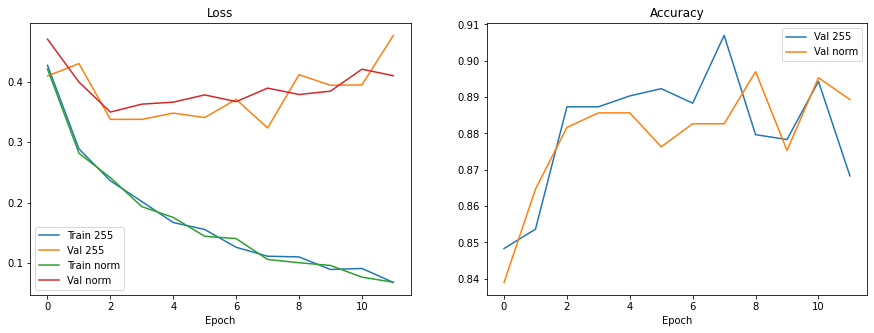

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(losses_255_train, label='Train 255')
ax[0].plot(losses_255_val, label='Val 255')
ax[0].plot(losses_norm_train, label='Train norm')
ax[0].plot(losses_norm_val, label='Val norm')
ax[0].set_xlabel('Epoch')
ax[0].set_title('Loss')
ax[0].legend()
ax[1].plot(accuracies_255_val, label='Val 255')
ax[1].plot(accuracies_norm_val, label='Val norm')
ax[1].set_xlabel('Epoch')
ax[1].set_title('Accuracy')
ax[1].legend()
plt.show()

Si vemos las gráficas del cuaderno pasado, se podría decir que una vez se han normalizado las imágenes en el dataset, el resultado es un poco mejor, se obtiene una accuracy un poco superior.
La mejora se notaría más en datasets con muchas más mejoras

Vamos a ver qué tal lo hace las redes con un ejemplo

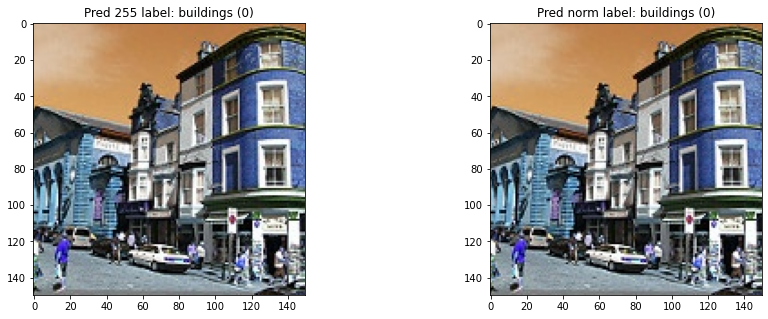

In [23]:
idx = np.random.randint(0, len(ds_pred_255))
_, sample_img = ds_pred_255[idx]

pred_255 = model_255(sample_img.unsqueeze(0).to(device))
pred_255 = pred_255.argmax(1).item()
key_255 = list(classes.keys())[list(classes.values()).index(pred_255)]

pred_norm = model_norm(sample_img.unsqueeze(0).to(device))
pred_norm = pred_norm.argmax(1).item()
key_norm = list(classes.keys())[list(classes.values()).index(pred_norm)]

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].imshow(sample_img.permute(1, 2, 0).numpy())
ax[0].set_title(f"Pred 255 label: {key_255} ({pred_255})")
ax[1].imshow(sample_img.permute(1, 2, 0).numpy())
ax[1].set_title(f"Pred norm label: {key_norm} ({pred_norm})")
plt.show()